In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [2]:
# Load data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRC4x6mecC7EkofiP3uJWZ3Y1jD1B2QMZXjlFtdP9-TOan6Fms2TqyOyssHegjTeG7iM6f-qX89vfvK/pub?gid=0&single=true&output=csv"
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y')
df.set_index('Date', inplace=True)
df['Biomass']=df['Biomass'].dropna()

In [3]:
# Assuming df is your DataFrame with the 'Biomass' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Biomass'].values.reshape(-1, 1))

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5  # Number of previous time steps to consider
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape input to be [samples, time steps, features]


In [4]:
# Create CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [5]:
# Train the model
model.fit(X, y, epochs=100, batch_size=32)


Epoch 1/100
3/3 [==============================] - 1s 7ms/step - loss: 0.2045
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 0.1427
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0920
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0571
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 12/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0331
Epoch 13/100
3/3 [==============================] - 0s 5ms/st

In [6]:
# Making predictions
predictions = model.predict(X)

# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y.reshape(-1, 1))

# Calculate error metrics
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R-squared: {r2}")


3/3 [==============================] - 0s 4ms/step
MSE: 780.0423197748488, RMSE: 27.929237722767315, MAE: 23.309868492713342, R-squared: 0.6874680716409158


In [7]:
# Forecast future values
future_months = 30
future_predictions = []
current_batch = scaled_data[-look_back:]

for i in range(future_months):
    current_pred = model.predict(current_batch.reshape(1, look_back, 1))
    future_predictions.append(current_pred[0, 0])
    current_batch = np.append(current_batch[1:], current_pred)

# Inverse transform the predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = pd.date_range(start=df.index[-1], periods=future_months + 1, freq='M')[1:]
future_series = pd.Series(future_predictions.flatten(), index=future_dates)


1/1 [==============================] - 0s 26ms/step


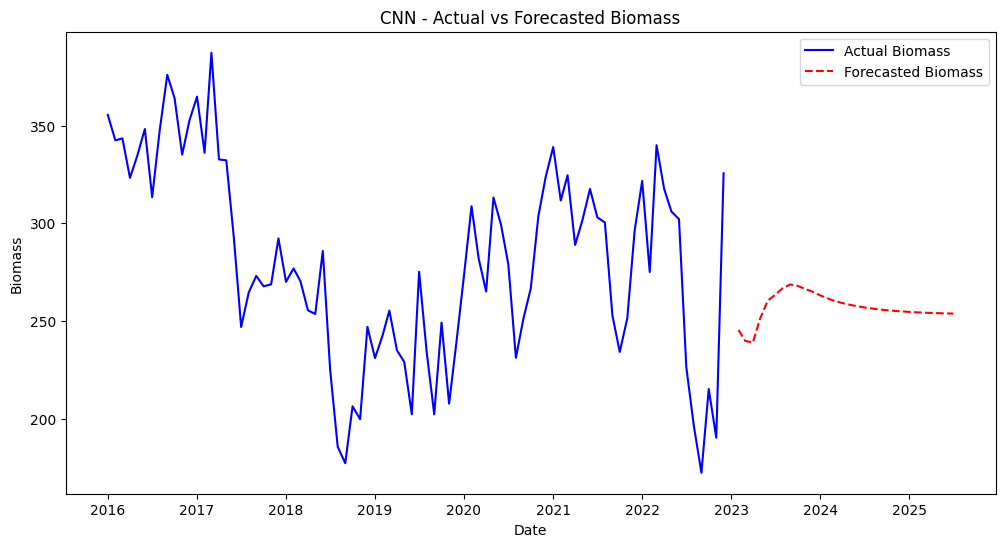

In [8]:
# Plotting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Biomass'], label='Actual Biomass', color='blue')
plt.plot(future_series.index, future_series, label='Forecasted Biomass', color='red', linestyle='dashed')
plt.title('CNN - Actual vs Forecasted Biomass')
plt.xlabel('Date')
plt.ylabel('Biomass')
plt.legend()
plt.show()
